In [5]:
!pip install gensim scikit-learn xgboost catboost
!pip install --upgrade --force-reinstall numpy pandas scikit-learn xgboost catboost gensim --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you h

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from gensim.models import Word2Vec
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
from google.colab import files

In [2]:
from google.colab import drive

# 드라이브 마운트
drive.mount('/content/drive')

# 경로 설정
file_path = '/content/drive/MyDrive/movie/filtered_over_100k_utf8sig.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 🎬 전처리
df['actor_list'] = df['actors'].fillna('').apply(lambda x: x.split('|'))
df['director_list'] = df['directors'].fillna('').apply(lambda x: [x.strip()])

In [4]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, GlobalAveragePooling1D

# 📦 배우 라벨 인코딩
actor_flat = [a for sublist in df['actor_list'] for a in sublist]
actor_encoder = LabelEncoder().fit(actor_flat)
df['actor_index_list'] = df['actor_list'].apply(lambda x: actor_encoder.transform([a for a in x if a in actor_encoder.classes_]))

# 📦 감독 라벨 인코딩
director_flat = [d for sublist in df['director_list'] for d in sublist]
director_encoder = LabelEncoder().fit(director_flat)
df['director_index_list'] = df['director_list'].apply(lambda x: director_encoder.transform([d for d in x if d in director_encoder.classes_]))

# 📦 패딩 및 시퀀스 정리
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_actor_len = 3  # 배우 수 제한
max_director_len = 1  # 감독 수 제한

actor_seq = pad_sequences(df['actor_index_list'], maxlen=max_actor_len)
director_seq = pad_sequences(df['director_index_list'], maxlen=max_director_len)

# 🎯 타겟값 (log scale)
y_target = np.log1p(df['audiCnt'].values)

# ✅ 모델 구성
actor_input = Input(shape=(max_actor_len,))
director_input = Input(shape=(max_director_len,))

actor_emb = Embedding(input_dim=len(actor_encoder.classes_), output_dim=16)(actor_input)
director_emb = Embedding(input_dim=len(director_encoder.classes_), output_dim=8)(director_input)

actor_vec = GlobalAveragePooling1D()(actor_emb)
director_vec = GlobalAveragePooling1D()(director_emb)

merged = Concatenate()([actor_vec, director_vec])
x = Dense(64, activation='relu')(merged)
x = Dense(32, activation='relu')(x)
out = Dense(1)(x)

model = Model(inputs=[actor_input, director_input], outputs=out)
model.compile(optimizer='adam', loss='mse')

# ✅ 학습
model.fit([actor_seq, director_seq], y_target, epochs=20, batch_size=32, verbose=1)

# ✅ 벡터 추출 함수 정의
actor_embedding_model = Model(inputs=actor_input, outputs=actor_vec)
director_embedding_model = Model(inputs=director_input, outputs=director_vec)

actor_vecs = actor_embedding_model.predict(actor_seq)
director_vecs = director_embedding_model.predict(director_seq)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 178.7401
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 159.2608
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.1624
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.8379
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3016
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3955
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6396
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3859
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2632
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1717
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1411
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1007
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0816
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0738
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0737
Epoch 16/20


In [5]:
# 🎭 장르 원핫 인코딩
df['genre_list'] = df['genres'].fillna('').apply(lambda x: x.split('|'))
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genre_list'])
print(genre_encoded[1])

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [6]:
# 🌎 국가 가중치 인코딩
nation_avg = df.groupby('nations')['audiCnt'].mean()
nation_weights = (nation_avg / nation_avg.max()).to_dict()
df['nation_weight_encoded'] = df['nations'].apply(lambda x: nation_weights.get(x, 0.0))
print(df['nation_weight_encoded'].iloc[50])

0.3879942252514979


In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import shap
import numpy as np

# ✅ 특징 이름 리스트 생성 (벡터 차원과 원핫 개수 반영)
feature_names = []

feature_names += [f'actor_vec_{i}' for i in range(actor_vecs.shape[1])]        # 16차원
feature_names += [f'director_vec_{i}' for i in range(director_vecs.shape[1])]  # 8차원
feature_names += [f'genre_{i}' for i in range(genre_encoded.shape[1])]         # One-hot 장르
feature_names += ['nation_weight']                                             # 국가 가중치

# ✅ 전체 입력 데이터 구성
X_all = np.hstack([actor_vecs, director_vecs, genre_encoded, df[['nation_weight_encoded']].values])
y_all = np.log1p(df['audiCnt'].values)

# ✅ 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# ✅ 모델 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
lgb_model = LGBMRegressor(n_estimators=100, random_state=42)
cat_model = CatBoostRegressor(n_estimators=100, verbose=0, random_state=42)

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)

# ✅ 평가
def eval_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  # 로그 되돌리기
    r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))
    print(f"{name:<15} RMSE: {rmse:,.2f} | R²: {r2:.4f}")

eval_model("Random Forest", rf_model, X_test, y_test)
eval_model("XGBoost", xgb_model, X_test, y_test)
eval_model("LightGBM", lgb_model, X_test, y_test)
eval_model("CatBoost", cat_model, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6127
[LightGBM] [Info] Number of data points in the train set: 772, number of used features: 39
[LightGBM] [Info] Start training from score 13.381135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [31]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_grouped_feature_importance(model, model_name, feature_names):
    # 1. 원래 feature importance 계산
    importances = model.feature_importances_

    # 2. prefix 기준으로 그룹핑 (예: 'actor_vec', 'director_vec' 등)
    group_importance = defaultdict(float)
    for fname, importance in zip(feature_names, importances):
        prefix = fname.split('_')[0] if 'vec' not in fname else '_'.join(fname.split('_')[:2])
        group_importance[prefix] += importance

    # 3. 정렬 후 상위 10개 시각화
    sorted_items = sorted(group_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    labels, values = zip(*sorted_items)

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(values)), values, align="center")
    plt.yticks(range(len(labels)), labels)
    plt.gca().invert_yaxis()
    plt.title(f"Grouped Feature Importance: {model_name}")
    plt.tight_layout()
    plt.show()


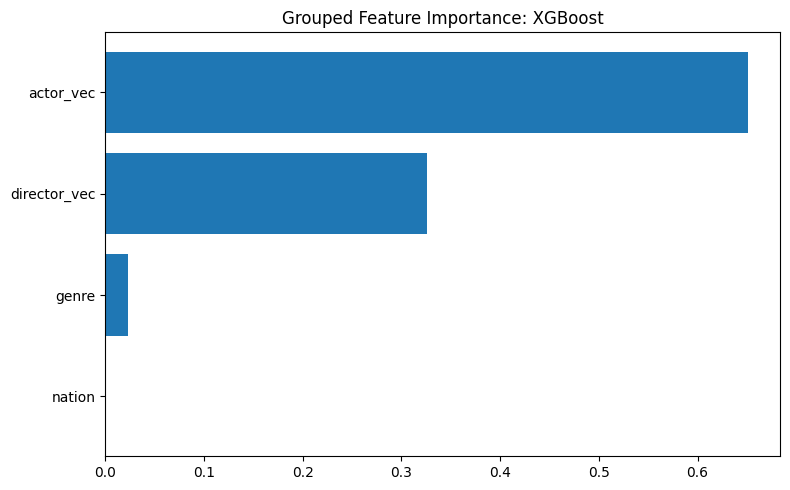

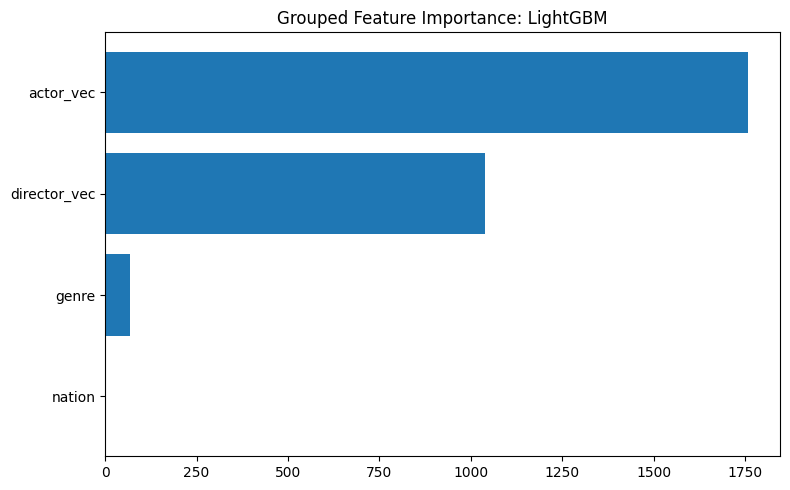

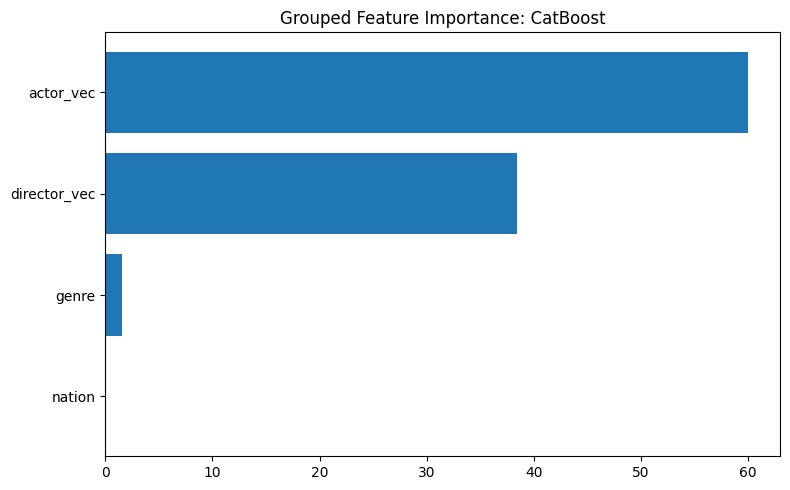

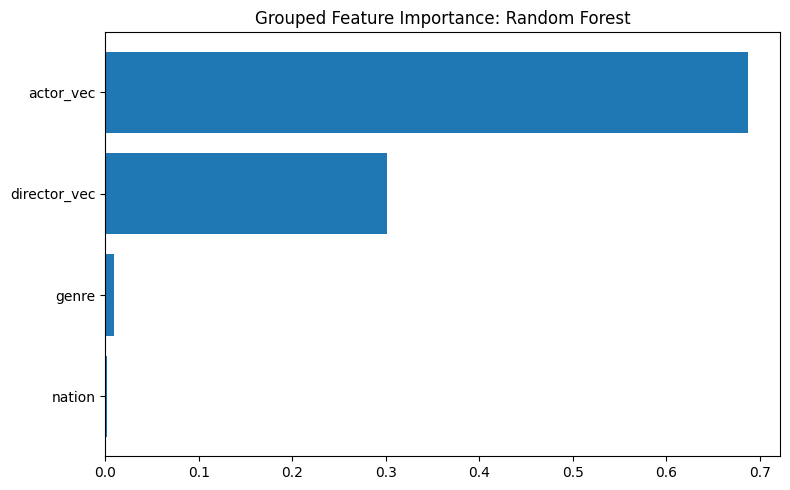

In [32]:
plot_grouped_feature_importance(xgb_model, "XGBoost", feature_names)
plot_grouped_feature_importance(lgb_model, "LightGBM", feature_names)
plot_grouped_feature_importance(cat_model, "CatBoost", feature_names)
plot_grouped_feature_importance(rf_model, "Random Forest", feature_names)

In [27]:
import shap

# 각 모델 별 SHAP 값 계산
shap_values_xgb = shap.TreeExplainer(xgb_model).shap_values(X_test)
shap_values_lgb = shap.TreeExplainer(lgb_model).shap_values(X_test)
shap_values_cat = shap.TreeExplainer(cat_model).shap_values(X_test)
shap_values_rf = shap.TreeExplainer(rf_model).shap_values(X_test)

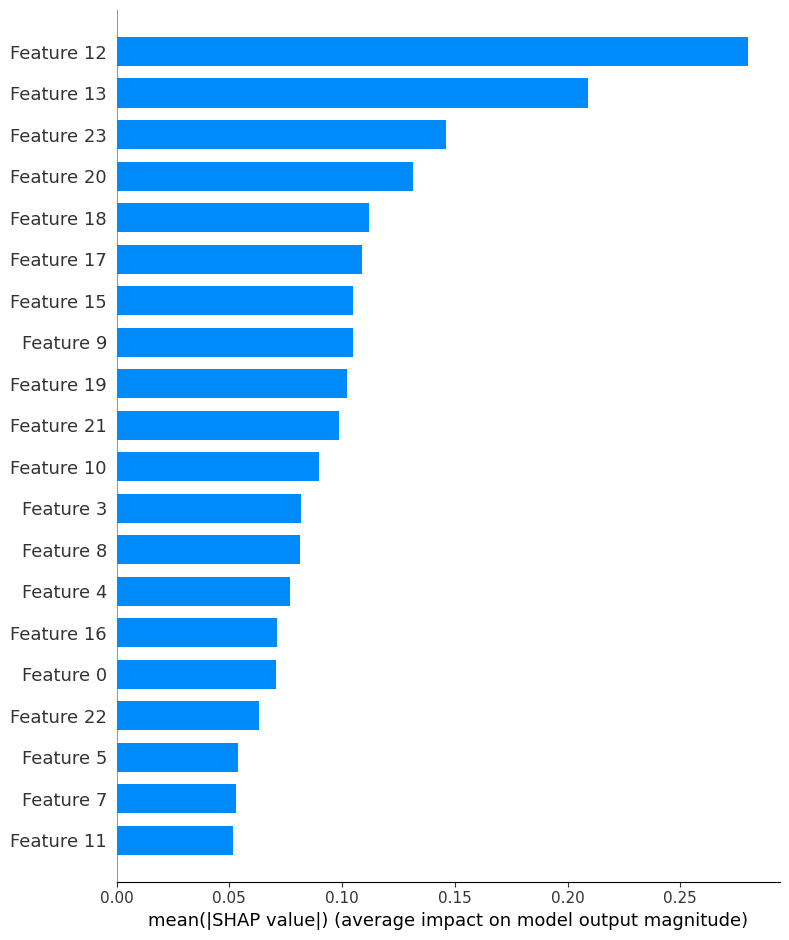

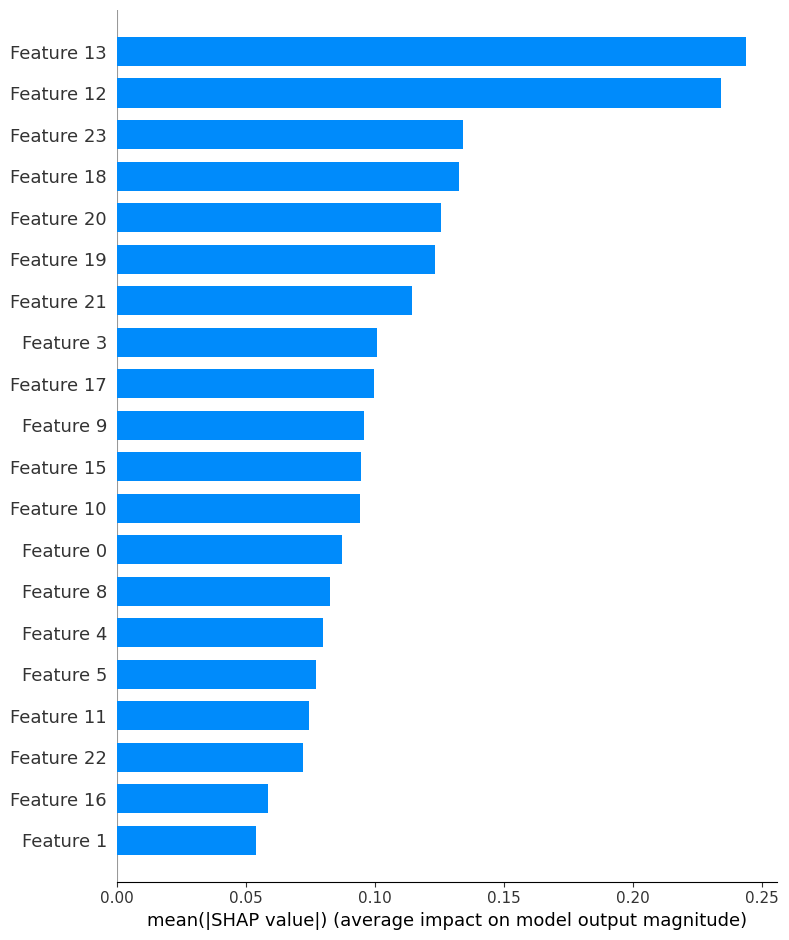

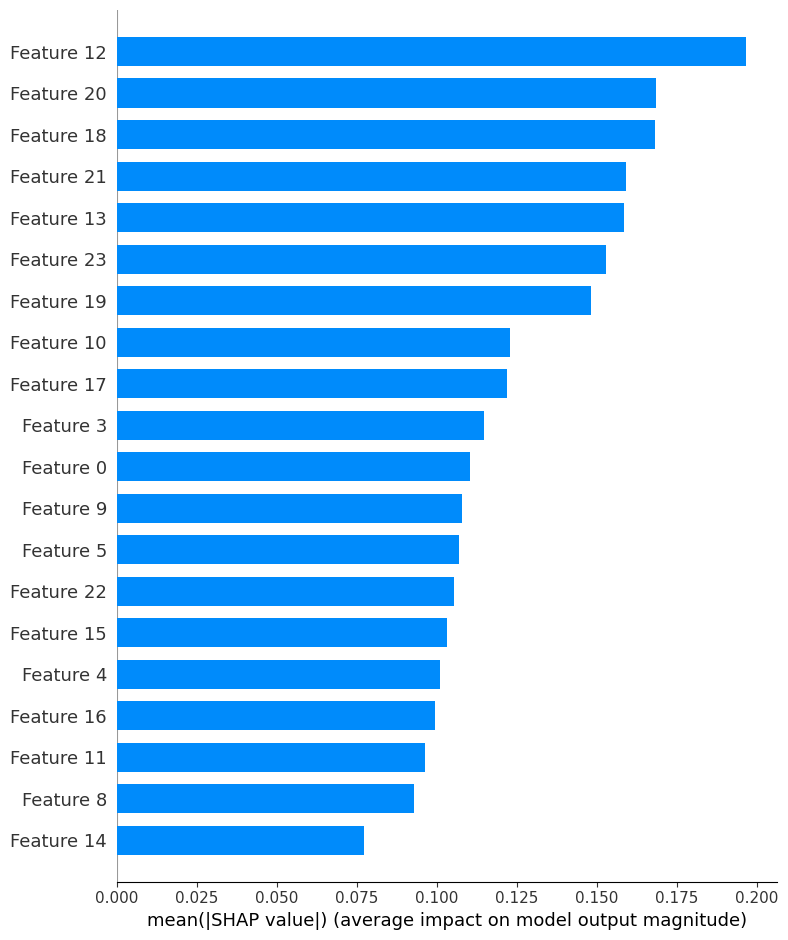

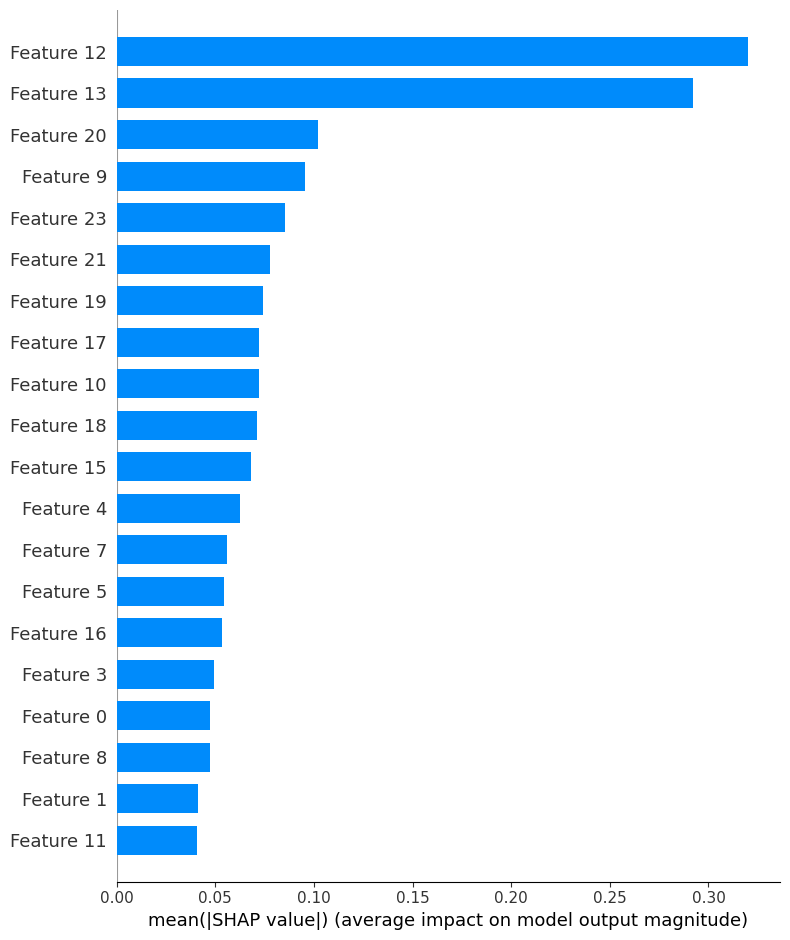

In [28]:
# 모델 별 SHAP 값 시각화
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", title="XGBoost SHAP Values")
shap.summary_plot(shap_values_lgb, X_test, plot_type="bar", title="LightGBM SHAP Values")
shap.summary_plot(shap_values_cat, X_test, plot_type="bar", title="CatBoost SHAP Values")
shap.summary_plot(shap_values_rf, X_test, plot_type="bar", title="Random Forest SHAP Values")